# Part 2 Fondamental Value Modeling

### Import

In [30]:
# Packages


import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
import os as os
Root_dir = ".."
Data_dir = os.path.join(Root_dir, "data_extraction", "raw_df")
#Data
#Price
price_d = pd.read_csv(os.path.join(Data_dir, "synthetic_price_daily_df.csv"),parse_dates=["Date"])
price_w = pd.read_csv(os.path.join(Data_dir, "synthetic_price_weekly_df.csv"),parse_dates=["Date"])
price_m = pd.read_csv(os.path.join(Data_dir, "synthetic_price_monthly_df.csv"),parse_dates=["Date"])
print(price_d.head())

#Div
div_d = pd.read_csv(os.path.join(Data_dir, "synthetic_div_daily_df.csv"),parse_dates=["Date"])
div_w = pd.read_csv(os.path.join(Data_dir, "synthetic_div_weekly_df.csv"),parse_dates=["Date"])
div_m = pd.read_csv(os.path.join(Data_dir, "synthetic_div_monthly_df.csv"),parse_dates=["Date"])
print(div_d.head())

#NDX100
nasdaq_d = pd.read_csv(os.path.join(Data_dir, "nasdaq_daily_df.csv"),parse_dates=["Date"])
nasdaq_d = nasdaq_d[["Date","Close"]]
nasdaq_w = pd.read_csv(os.path.join(Data_dir, "nasdaq_weekly_df.csv"),parse_dates=["Date"])
nasdaq_w = nasdaq_w[["Date","Close"]]
nasdaq_m = pd.read_csv(os.path.join(Data_dir, "nasdaq_monthly_df.csv"),parse_dates=["Date"])
nasdaq_m = nasdaq_m[["Date","Close"]]
print(nasdaq_d.head())


                        Date  Synthetic Index Close Price
0  2002-01-01 00:00:00-05:00                     6.747791
1  2002-01-02 00:00:00-05:00                     6.851966
2  2002-01-03 00:00:00-05:00                     7.060761
3  2002-01-04 00:00:00-05:00                     7.045765
4  2002-01-05 00:00:00-05:00                     7.045765
                        Date  Synthetic Index Dividend
0  2002-01-01 00:00:00-05:00                       0.0
1  2002-01-02 00:00:00-05:00                       0.0
2  2002-01-03 00:00:00-05:00                       0.0
3  2002-01-04 00:00:00-05:00                       0.0
4  2002-01-05 00:00:00-05:00                       0.0
        Date        Close
0 2002-01-02  1610.390015
1 2002-01-03  1666.660034
2 2002-01-04  1675.030029
3 2002-01-07  1649.829956
4 2002-01-08  1666.579956
Empty DataFrame
Columns: [Date, Close]
Index: []


## Index Tracking (VS Ndx100)

Joined shape: (6008, 2)


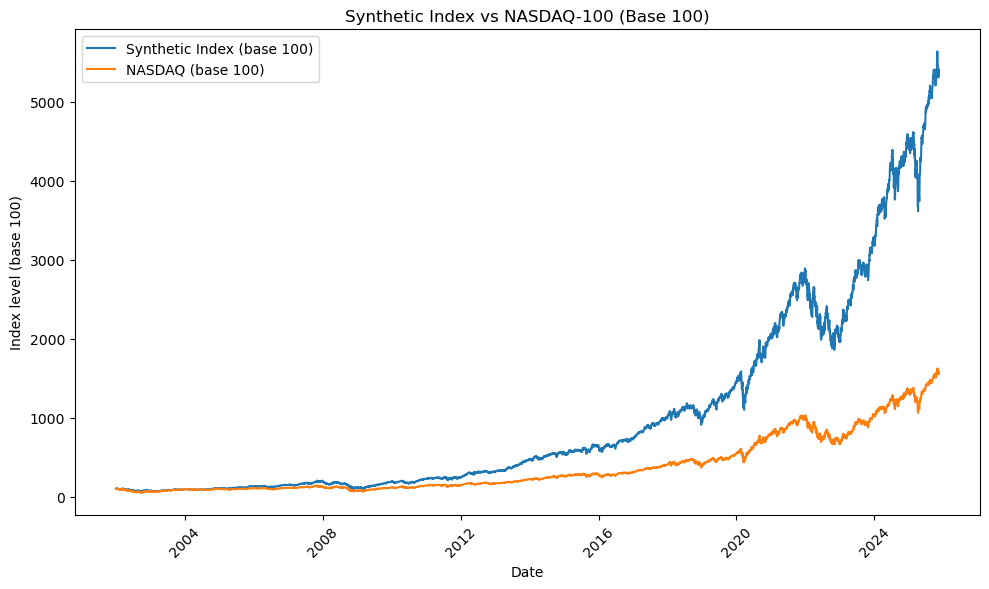

In [81]:
import matplotlib.pyplot as plt
import pandas as pd

for df in (price_d, nasdaq_d):
    df["Date"] = pd.to_datetime(df["Date"], utc=True)
    df["Date"] = df["Date"].dt.tz_convert(None)
    df["Date"] = df["Date"].dt.normalize()

p = price_d.set_index("Date")[["Synthetic Index Close Price"]]
n = nasdaq_d.set_index("Date")[["Close"]]

df = p.join(n, how="inner").sort_index()

print("Joined shape:", df.shape)

if df.empty:
    raise ValueError("No overlapping dates between price_d and nasdaq_d after alignment.")

df_base100 = df / df.iloc[0] * 100

plt.figure(figsize=(10,6))
plt.plot(df_base100.index,
         df_base100["Synthetic Index Close Price"],
         label="Synthetic Index (base 100)")
plt.plot(df_base100.index,
         df_base100["Close"],
         label="NASDAQ (base 100)")

plt.xlabel("Date")
plt.ylabel("Index level (base 100)")
plt.title("Synthetic Index vs NASDAQ-100 (Base 100)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### Regression of Nasdaq = alpha + Synthetic Index * beta

In [89]:
import statsmodels.api as sm

for df in (price_d, nasdaq_d):
    df["Date"] = pd.to_datetime(df["Date"], utc=True)
    df["Date"] = df["Date"].dt.tz_convert(None)
    df["Date"] = df["Date"].dt.normalize()

p = price_d.set_index("Date")[["Synthetic Index Close Price"]]
n = nasdaq_d.set_index("Date")[["Close"]]

df = p.join(n, how="inner").sort_index()
print(df)

y = df["Close"]


X = df["Synthetic Index Close Price"]

X1 = sm.add_constant(X)
ols = sm.OLS(y, X1).fit()

print(ols.summary())


alpha = ols.params["const"]
beta = ols.params[X.name]


df["synthetic_scaled"] = alpha + beta * df["Synthetic Index Close Price"]

ols_no_const = sm.OLS(y, X).fit()
beta_nc = ols_no_const.params[X.name]

df["synthetic_scaled_no_const"] = beta_nc * df["Synthetic Index Close Price"]


            Synthetic Index Close Price         Close
Date                                                 
2002-01-02                     6.851966   1610.390015
2002-01-03                     7.060761   1666.660034
2002-01-04                     7.045765   1675.030029
2002-01-07                     6.988634   1649.829956
2002-01-08                     7.027469   1666.579956
...                                 ...           ...
2025-11-10                   370.727983  25611.740234
2025-11-11                   370.647453  25533.490234
2025-11-12                   370.626492  25517.330078
2025-11-13                   364.371439  24993.460938
2025-11-14                   365.340212  25008.240234

[6008 rows x 2 columns]
                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Square

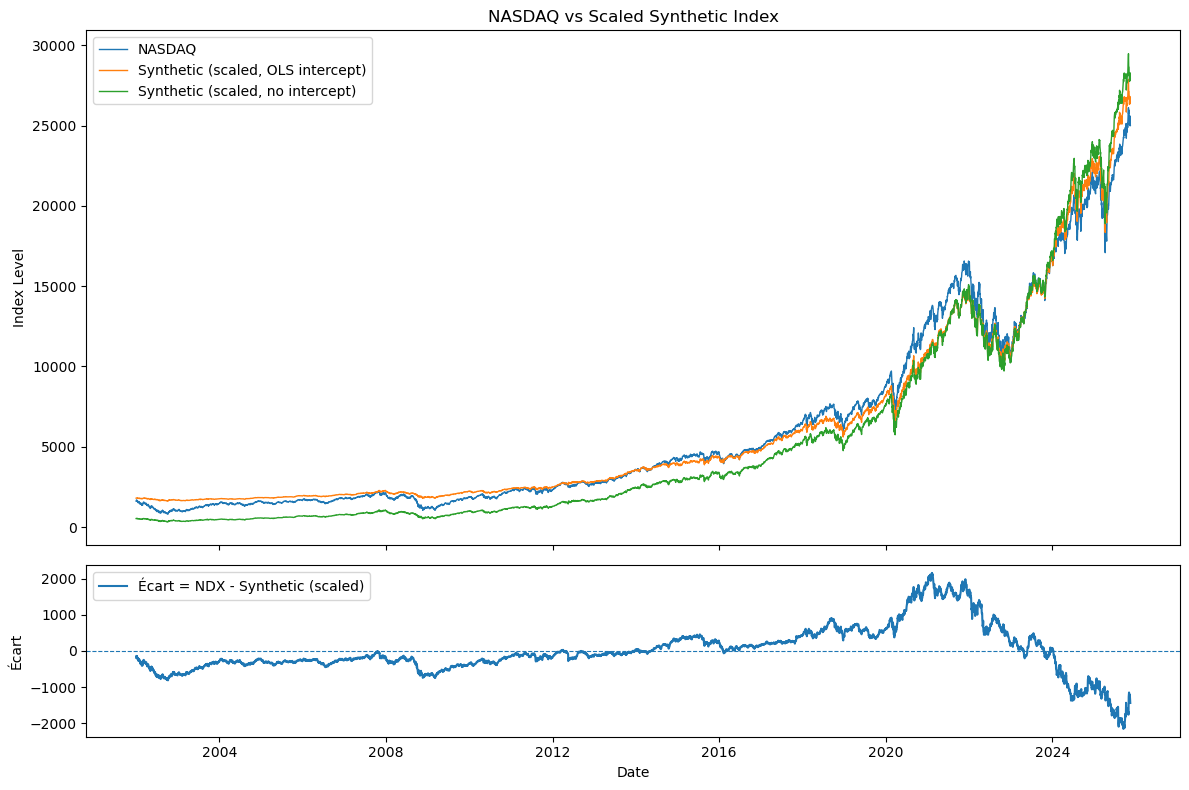

In [98]:
import matplotlib.pyplot as plt

df["ecart"] = df["Close"] - df["synthetic_scaled"]
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(12, 8),
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]}
)

ax1.plot(df.index, df["Close"], label="NASDAQ", linewidth=1)
ax1.plot(df.index, df["synthetic_scaled"], label="Synthetic (scaled, OLS intercept)", linewidth=1)
ax1.plot(df.index, df["synthetic_scaled_no_const"], label="Synthetic (scaled, no intercept)", linewidth=1)

ax1.set_title("NASDAQ vs Scaled Synthetic Index")
ax1.set_ylabel("Index Level")
ax1.legend(loc="upper left")

ax2.plot(df.index, df["ecart"], label="Écart = NDX - Synthetic (scaled)")
ax2.axhline(0, linestyle="--", linewidth=0.8)
ax2.set_ylabel("Écart")
ax2.set_xlabel("Date")
ax2.legend(loc="upper left")

plt.tight_layout()
plt.show()


####
NDX ≈ 1328.3552 + 68.7614 * Synthetic


## Cointegration

### Data prep


In [71]:

for df in (price_m, div_m):
    df["Date"] = pd.to_datetime(df["Date"], utc=True)
    df["Date"] = df["Date"].dt.tz_convert(None)   # drop timezone
    df["Date"] = df["Date"].dt.normalize()        # keep only yyyy-mm-dd (00:00:00)

p = price_m.set_index("Date")[["Synthetic Index Close Price"]]
n = div_m.set_index("Date")[["Synthetic Index Dividend"]]
df_m = p.join(n, how="inner").sort_index()

print("Joined shape:", df.shape)  # sanity check

if df_m.empty:
    raise ValueError("No overlapping dates between price_d and nasdaq_d after alignment.")
df_m = df_m.rename(
    columns={
        "Synthetic Index Close Price": "P",
        "Synthetic Index Dividend": "D"
    }
)
print(df_m)



Joined shape: (287, 2)
                     P         D
Date                            
2002-01-01    6.747791  0.000382
2002-02-01    6.713567  0.006262
2002-03-01    6.619971  0.002720
2002-04-01    6.720307  0.001222
2002-05-01    6.026849  0.003142
...                ...       ...
2025-07-01  333.590679  0.055846
2025-08-01  340.899950  0.253449
2025-09-01  348.953859  0.216313
2025-10-01  366.698338  0.076930
2025-11-01  375.264182  0.061543

[287 rows x 2 columns]


In [72]:
df_m = df_m[df_m["P"] > 0]
df_m = df_m[df_m["D"] > 0]


df_m["p"] = np.log(df_m["P"])
df_m["D12"] = df_m["D"].rolling(window=12, min_periods=12).sum()
df_m["d"] = np.log(df_m["D"])
df_m["d12"] = np.log(df_m["D12"])

# Campbell's log dividend–price ratio
df_m["dp"] = df_m["d"] - df_m["p"]
df_m["d12p"] = df_m["d12"] - df_m["p"]
df_m = df_m.dropna(subset=["D12"])
print(df_m)


                     P         D         p       D12         d       d12  \
Date                                                                       
2002-12-01    5.501878  0.003610  1.705089  0.033602 -5.624125 -3.393184   
2003-01-01    4.864463  0.000381  1.581956  0.033601 -7.871917 -3.393210   
2003-02-01    4.608511  0.019004  1.527905  0.046343 -3.963097 -3.071691   
2003-03-01    4.656791  0.003212  1.538327  0.046835 -5.740833 -3.061119   
2003-04-01    4.726250  0.000393  1.553132  0.046006 -7.842065 -3.078981   
...                ...       ...       ...       ...       ...       ...   
2025-07-01  333.590679  0.055846  5.809915  2.022016 -2.885165  0.704095   
2025-08-01  340.899950  0.253449  5.831589  2.059450 -1.372591  0.722439   
2025-09-01  348.953859  0.216313  5.854940  2.074903 -1.531027  0.729915   
2025-10-01  366.698338  0.076930  5.904540  2.101338 -2.564857  0.742574   
2025-11-01  375.264182  0.061543  5.927630  1.918976 -2.788022  0.651791   

           

### Engle-Granger for log Div / log Price

In [49]:


p = df_m["p"]
d = df_m["d"]


X = sm.add_constant(d)
ols_res = sm.OLS(p, X).fit()
print(ols_res.summary())


u_hat = ols_res.resid

adf_stat, adf_p, _, _, crit_vals, _ = adfuller(u_hat, maxlag=12, regression='c')

print("\nEngle–Granger residual ADF test:")
print(f"ADF statistic: {adf_stat:.3f}")
print(f"p-value      : {adf_p:.3f}")
print("Critical values:", crit_vals)


                            OLS Regression Results                            
Dep. Variable:                      p   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     225.7
Date:                Fri, 21 Nov 2025   Prob (F-statistic):           2.95e-37
Time:                        13:25:19   Log-Likelihood:                -346.94
No. Observations:                 265   AIC:                             697.9
Df Residuals:                     263   BIC:                             705.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6056      0.144     39.014      0.0

### Campbell approach log(Dt/Pt)

In [50]:
adf_dp = adfuller(df_m["dp"], maxlag=12, regression='c')
dp_stat, dp_p, _, _, dp_crit, _ = adf_dp

print("\nADF test on dp_t = log(D) - log(P):")
print(f"ADF statistic: {dp_stat:.3f}")
print(f"p-value      : {dp_p:.3f}")
print("Critical values:", dp_crit)



ADF test on dp_t = log(D) - log(P):
ADF statistic: -2.234
p-value      : 0.194
Critical values: {'1%': -3.4564641849494113, '5%': -2.873032730098417, '10%': -2.572894516864816}


### Engle-Granger for log Div12 / log Price

In [64]:


p = df_m["p"]
d = df_m["d12"]


X = sm.add_constant(d)
ols_res = sm.OLS(p, X).fit()
print(ols_res.summary())


u_hat = ols_res.resid

adf_stat, adf_p, _, _, crit_vals, _ = adfuller(u_hat, maxlag=12, regression='c')

print("\nEngle–Granger residual ADF test:")
print(f"ADF statistic: {adf_stat:.3f}")
print(f"p-value      : {adf_p:.3f}")
print("Critical values:", crit_vals)


                            OLS Regression Results                            
Dep. Variable:                      p   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     1314.
Date:                Fri, 21 Nov 2025   Prob (F-statistic):          2.87e-104
Time:                        13:31:34   Log-Likelihood:                -191.76
No. Observations:                 265   AIC:                             387.5
Df Residuals:                     263   BIC:                             394.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4741      0.039    115.096      0.0

### Campbelle Approach for log(Div12/Price)

In [67]:
adf_dp = adfuller(df_m["d12p"], maxlag=12, regression='c')
dp_stat, dp_p, _, _, dp_crit, _ = adf_dp

print("\nADF test on dp_t = log(D12) - log(P):")
print(f"ADF statistic: {dp_stat:.3f}")
print(f"p-value      : {dp_p:.3f}")
print("Critical values:", dp_crit)



ADF test on dp_t = log(D12) - log(P):
ADF statistic: -1.717
p-value      : 0.422
Critical values: {'1%': -3.4565688966099373, '5%': -2.8730786194395455, '10%': -2.5729189953388762}


### Test of Coint-Johansen

In [75]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
cj = coint_johansen(df_m[["p", "d12"]].dropna(), det_order=0, k_ar_diff=2)
# Trace statistics
print("Trace statistics (lr1):", cj.lr1)
print("Trace critical values (cvt):")
print(cj.cvt)   # rows = r=0, r<=1; cols = 90%, 95%, 99%

# Max-eigenvalue statistics
print("Max-eig statistics (lr2):", cj.lr2)
print("Max-eig critical values (cvm):")
print(cj.cvm)

beta = cj.evec[:, 0]          # first cointegrating vector (2x1)
print("Raw beta:", beta)

# normalize so coefficient on p is 1
beta_p_norm = beta / beta[0]
print("Cointegrating vector (p = 1):", beta_p_norm)


Trace statistics (lr1): [15.26755825  0.11137628]
Trace critical values (cvt):
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Max-eig statistics (lr2): [15.15618197  0.11137628]
Max-eig critical values (cvm):
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]
Raw beta: [ 1.71618203 -2.49465362]
Cointegrating vector (p = 1): [ 1.         -1.45360666]
